In [1]:
suppressMessages({
  library(DESeq2)
})

In [2]:
library("tximport")
library("rhdf5")
library(stringr)
library(dplyr)


Attaching package: 'dplyr'


The following object is masked from 'package:Biobase':

    combine


The following object is masked from 'package:matrixStats':

    count


The following objects are masked from 'package:GenomicRanges':

    intersect, setdiff, union


The following object is masked from 'package:GenomeInfoDb':

    intersect


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [3]:
proj = "/project/fudenber_735/collaborations/karissa_2022"
ensembl_relations = "/project/fudenber_735/genomes/mm10/ensembl/ensembl_relational_downloads"
elphege_proj_files = "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652"

In [4]:
# building s2c table

meta <- read.table(file.path(proj, "RNAseq", "fastq", "KHRNA_Libraries_Nora-Fudenberg.csv"), 
                   sep=',', 
                   header=TRUE,
                  stringsAsFactors=FALSE)

In [5]:
meta <- meta %>% 
          dplyr::rename(
            library = X...library)

#names(meta)[0] <- "library"

In [6]:
meta

library,cell.line,cell.type,genotype,treatment,replicate,Illumina.Index,CAT.submission
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
KHRNA22,EA18.1,ESC,NIPBL-FKBP,DMSO 24h,1,UDP0028,KHEN02
KHRNA23,EA18.1,ESC,NIPBL-FKBP,DMSO 24h,2,UDP0033,KHEN02
KHRNA50,EA18.1,ESC,NIPBL-FKBP,DMSO 24h,4,UDP0006,KHEN03
KHRNA25,EA18.1,ESC,NIPBL-FKBP,dTAG-13 24h,1,UDP0029,KHEN02
KHRNA26,EA18.1,ESC,NIPBL-FKBP,dTAG-13 24h,2,UDP0034,KHEN02
KHRNA51,EA18.1,ESC,NIPBL-FKBP,dTAG-13 24h,4,UDP0071,KHEN03


In [7]:
s2c <- dplyr::select(meta, sample = library, condition = treatment)
s2c$condition <- gsub(' ', '_', s2c$condition)
s2c$condition <- gsub('-', '_', s2c$condition)
s2c$condition <- factor(s2c$condition,
                        levels = c("DMSO_24h", "dTAG_13_24h"))

In [8]:
s2c

sample,condition
<chr>,<fct>
KHRNA22,DMSO_24h
KHRNA23,DMSO_24h
KHRNA50,DMSO_24h
KHRNA25,dTAG_13_24h
KHRNA26,dTAG_13_24h
KHRNA51,dTAG_13_24h


In [9]:
write.csv(s2c ,file.path(proj, "RNAseq-mapped", paste("s2c", "_DMSO_24h_vs_dTAG_13_24h", ".csv", sep="")))

In [51]:
files <- file.path(proj, "RNAseq-mapped", "kallisto", meta$library, "abundance.h5")
names(files) <- str_split_fixed(files,'/',9)[,8]

In [53]:
files

KHRNA22 
"/project/fudenber_735/collaborations/karissa_2022/RNAseq-mapped/kallisto/KHRNA22/abundance.h5" 
                                                                                        KHRNA23 
"/project/fudenber_735/collaborations/karissa_2022/RNAseq-mapped/kallisto/KHRNA23/abundance.h5" 
                                                                                        KHRNA50 
"/project/fudenber_735/collaborations/karissa_2022/RNAseq-mapped/kallisto/KHRNA50/abundance.h5" 
                                                                                        KHRNA25 
"/project/fudenber_735/collaborations/karissa_2022/RNAseq-mapped/kallisto/KHRNA25/abundance.h5" 
                                                                                        KHRNA26 
"/project/fudenber_735/collaborations/karissa_2022/RNAseq-mapped/kallisto/KHRNA26/abundance.h5" 
                                                                                        KHRNA51 
"/project/fudenber_735/collaborations/karissa_2022/RNAseq-mapped/kallisto/KHRNA51/abundance.h5"

In [54]:
tx2gene <- read.csv(file.path(ensembl_relations,"biomaRt_mm10_t2g.csv"))[,-1]

In [55]:
tx_by_genes <- tximport(
                 files,
                 type = "kallisto", 
                 tx2gene = tx2gene, 
                 ignoreAfterBar = TRUE
                )

1 
2 
3 
4 
5 
6 


transcripts missing from tx2gene: 8427

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



In [63]:
# exporting abundances 
write.csv(tx_by_genes$counts, file.path(proj, "RNAseq-mapped", "tximport", "gene-counts.csv"))

In [13]:
dds <- DESeqDataSetFromTximport(tx_by_genes,
                                colData = s2c,
                                design = ~ condition)

using counts and average transcript lengths from tximport



In [14]:
dds

class: DESeqDataSet 
dim: 29723 6 
metadata(1): version
assays(2): counts avgTxLength
rownames(29723): ENSMUSG00000000001 ENSMUSG00000000003 ...
  ENSMUSG00000099113 ENSMUSG00000099329
rowData names(0):
colnames(6): KHRNA22 KHRNA23 ... KHRNA26 KHRNA51
colData names(2): sample condition

In [15]:
dds <- DESeq(dds)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [16]:
head(results(dds), 10)

log2 fold change (MLE): condition dTAG 13 24h vs DMSO 24h 
Wald test p-value: condition dTAG 13 24h vs DMSO 24h 
DataFrame with 10 rows and 6 columns
                      baseMean log2FoldChange     lfcSE      stat      pvalue
                     <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000000001 4292.214151     -0.1015234  0.100625 -1.008924 3.13011e-01
ENSMUSG00000000003    0.000000             NA        NA        NA          NA
ENSMUSG00000000028 1694.940934     -0.0713420  0.117240 -0.608512 5.42848e-01
ENSMUSG00000000031   50.489910      1.7234198  0.416543  4.137436 3.51208e-05
ENSMUSG00000000037  196.342074     -0.5612423  0.448194 -1.252232 2.10485e-01
ENSMUSG00000000049    0.163406      1.1039082  4.080473  0.270534 7.86749e-01
ENSMUSG00000000056  871.917098      0.3791893  0.116249  3.261877 1.10677e-03
ENSMUSG00000000058    0.156952      1.1039082  4.080473  0.270534 7.86749e-01
ENSMUSG00000000078  969.549826     -0.0385543  0.137075 -0.281264 7.78

In [17]:
dds

class: DESeqDataSet 
dim: 29723 6 
metadata(1): version
assays(6): counts avgTxLength ... H cooks
rownames(29723): ENSMUSG00000000001 ENSMUSG00000000003 ...
  ENSMUSG00000099113 ENSMUSG00000099329
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(6): KHRNA22 KHRNA23 ... KHRNA26 KHRNA51
colData names(2): sample condition

In [18]:
cond = "dTAG_13_24h_vs_DMSO_24h"
res <- results(dds, alpha=0.05)

write.csv(res,file.path(proj, "RNAseq-mapped", "DE-results", paste("pairwise_deseq_wt_", cond, ".csv", sep="")))

In [1]:
plotMA(res, ylim=c(-8,8))

ERROR: Error in plotMA(res, ylim = c(-8, 8)): could not find function "plotMA"


In [19]:
head(res, 5)

log2 fold change (MLE): condition dTAG 13 24h vs DMSO 24h 
Wald test p-value: condition dTAG 13 24h vs DMSO 24h 
DataFrame with 5 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000000001 4292.2142      -0.101523  0.100625 -1.008924 3.13011e-01
ENSMUSG00000000003    0.0000             NA        NA        NA          NA
ENSMUSG00000000028 1694.9409      -0.071342  0.117240 -0.608512 5.42848e-01
ENSMUSG00000000031   50.4899       1.723420  0.416543  4.137436 3.51208e-05
ENSMUSG00000000037  196.3421      -0.561242  0.448194 -1.252232 2.10485e-01
                        padj
                   <numeric>
ENSMUSG00000000001 0.7249787
ENSMUSG00000000003        NA
ENSMUSG00000000028 0.8681955
ENSMUSG00000000031 0.0012514
ENSMUSG00000000037 0.6128376

In [20]:
dNipbl = as.data.frame(res)

In [21]:
head(dNipbl, 5)
dim(dNipbl)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,4292.21415,-0.10152343,0.1006254,-1.0089242,0.3130110053,0.724978743
ENSMUSG00000000003,0.00000,NA,NA,NA,NA,NA
ENSMUSG00000000028,1694.94093,-0.07134204,0.1172402,-0.6085119,0.5428480184,0.868195533
ENSMUSG00000000031,50.48991,1.72341985,0.4165429,4.1374362,0.0000351208,0.001251401
ENSMUSG00000000037,196.34207,-0.56124233,0.4481935,-1.2522322,0.2104852735,0.612837643


[1] 29723     6

# Compare DE of dNipbl and dCTCF genes

See basic-deseq-mm9, adjusted the input/output files to generate DESeq2 output for mm10 mapping

In [22]:
library(ggplot2)
library("ggVennDiagram")

ERROR: Error in library("ggVennDiagram"): there is no package called 'ggVennDiagram'


In [23]:
dCTCF <- read.csv(file.path(elphege_proj_files, "deseq-mm10-results", paste("pairwise_deseq_wt_", "CTCF_AID_auxin1day.csv", sep="")), header=TRUE)

In [24]:
head(dCTCF, 5)
dim(dCTCF)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000000001,4946.9216,-0.03082289,0.2524125,-0.1221132,9.028094e-01,0.999976277
2,ENSMUSG00000000003,0.0000,NA,NA,NA,NA,NA
3,ENSMUSG00000000028,2277.2352,-0.09174769,0.1766256,-0.5194472,6.034489e-01,0.999976277
4,ENSMUSG00000000031,27.6991,-0.32988401,0.6413135,-0.5143880,6.069807e-01,0.999976277
5,ENSMUSG00000000037,330.5182,2.02001132,0.5094480,3.9650981,7.336576e-05,0.007283521


[1] 29723     7

In [25]:
# Maybe a little scatter plot
allDEG = merge(x=dNipbl, y=dCTCF, by.x=0, by.y="X", all=TRUE)

In [26]:
head(allDEG, 5)

,Row.names,baseMean.x,log2FoldChange.x,lfcSE.x,stat.x,pvalue.x,padj.x,baseMean.y,log2FoldChange.y,lfcSE.y,stat.y,pvalue.y,padj.y
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000000001,4292.21415,-0.10152343,0.1006254,-1.0089242,0.3130110053,0.724978743,4946.9216,-0.03082289,0.2524125,-0.1221132,9.028094e-01,0.999976277
2,ENSMUSG00000000003,0.00000,NA,NA,NA,NA,NA,0.0000,NA,NA,NA,NA,NA
3,ENSMUSG00000000028,1694.94093,-0.07134204,0.1172402,-0.6085119,0.5428480184,0.868195533,2277.2352,-0.09174769,0.1766256,-0.5194472,6.034489e-01,0.999976277
4,ENSMUSG00000000031,50.48991,1.72341985,0.4165429,4.1374362,0.0000351208,0.001251401,27.6991,-0.32988401,0.6413135,-0.5143880,6.069807e-01,0.999976277
5,ENSMUSG00000000037,196.34207,-0.56124233,0.4481935,-1.2522322,0.2104852735,0.612837643,330.5182,2.02001132,0.5094480,3.9650981,7.336576e-05,0.007283521


Warning message:
"Removed 6944 rows containing missing values (geom_point)."


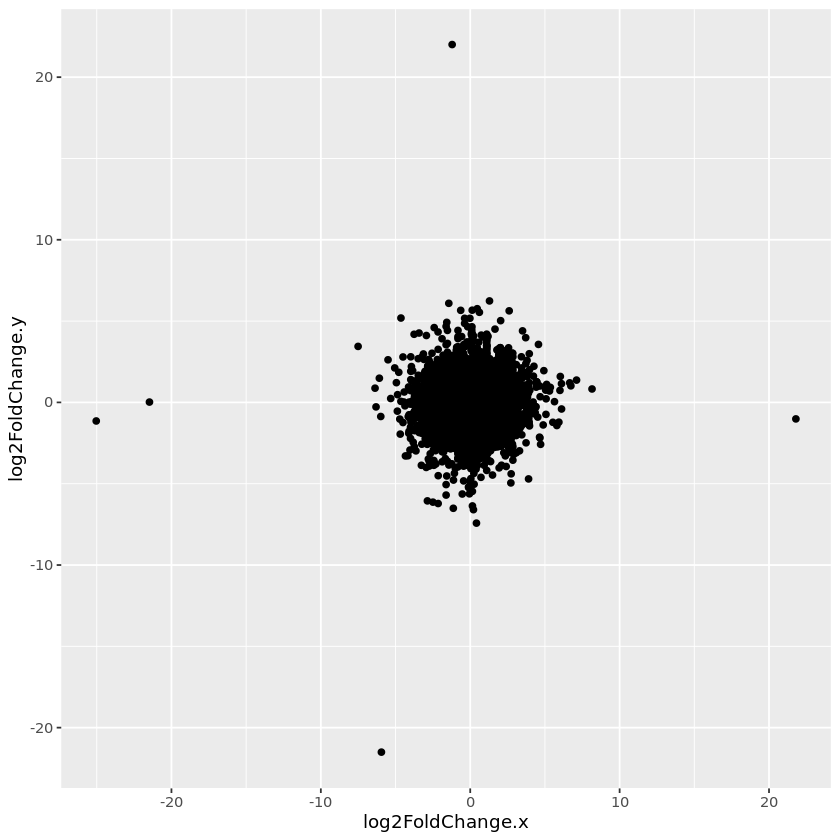

In [27]:
# scatter plot: raw abundances WT-CTCF, WT-nipBl, depletion after 24 hours for each of the two

ggplot(allDEG, aes(x=log2FoldChange.x, y=log2FoldChange.y)) + geom_point()

# Comparing results from STAR vs Kallisto

In [29]:
StarFeatureCount <- read.csv(file.path('/project/fudenber_735/collaborations/karissa_2022/RNAseq/STAR_Gencode_alignment/20220304_featureCounts_EA18-1_dTAG13-24h.csv'))


In [30]:
head(StarFeatureCount, 10)

,X,KHRNA22,KHRNA23,KHRNA25,KHRNA26,KHRNA50,KHRNA51
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSMUSG00000000001.4,5220,5438,4263,4021,3298,3160
2,ENSMUSG00000000003.15,0,0,0,0,0,0
3,ENSMUSG00000000028.15,1972,2195,1655,1709,1328,1246
4,ENSMUSG00000000031.16,41,18,72,44,10,70
5,ENSMUSG00000000037.17,174,140,132,107,170,166
6,ENSMUSG00000000049.11,0,0,0,0,0,0
7,ENSMUSG00000000056.7,944,904,982,1014,538,748
8,ENSMUSG00000000058.6,0,0,1,0,0,0
9,ENSMUSG00000000078.7,1124,1074,924,888,790,782


In [46]:
str_split(files['KHRNA22'], '.h5', n=2)[1]

[[1]]
[1] "/project/fudenber_735/collaborations/karissa_2022/RNAseq-mapped/kallisto/KHRNA22/abundance"
[2] ""